In [1]:
from obspy.core import Stream, UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
from matplotlib.mlab import csd
from obspy.signal.spectral_estimation import get_nlnm, get_nhnm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

We should grab some data and estimate some cross-spectra

In [2]:
net, sta, loc, chan = 'IU', 'TUC', '*', 'BHZ'
stime = UTCDateTime('2019-200T00:00:00')
etime = stime + 6*60*60
client = Client('IRIS')

In [3]:
st = client.get_waveforms(net, sta, loc, chan, stime, etime, attach_response=True)
print(st)

3 Trace(s) in Stream:
IU.TUC.00.BHZ | 2019-07-19T00:00:00.019538Z - 2019-07-19T05:59:59.994538Z | 40.0 Hz, 864000 samples
IU.TUC.10.BHZ | 2019-07-19T00:00:00.019538Z - 2019-07-19T05:59:59.994538Z | 40.0 Hz, 864000 samples
IU.TUC.60.BHZ | 2019-07-19T00:00:00.019538Z - 2019-07-19T05:59:59.969538Z | 20.0 Hz, 432000 samples


In [4]:
for tr in st:
    if tr.stats.sampling_rate == 40:
        tr.decimate(2)

Now we make a function to compute the self-noise and the power spectral densities of our data.  This comes from equation 14 of Sleeman et al. (2006).

In [5]:
def cp(tr1, tr2, lenfft, lenol, delta):
    # Cross-power function
    cpval,fre = csd(tr1.data, tr2.data, NFFT=lenfft, Fs=1./float(delta), 
                    noverlap=int(lenol*lenfft), scale_by_freq=True)
    fre, cpval = fre[1:], cpval[1:]
    return cpval, fre

def selfnoise(st, length, overlap):
    p00, f = cp(st[0],st[0],length,overlap,st[0].stats.delta)
    p11, f = cp(st[1],st[1],length,overlap,st[0].stats.delta)
    p22, f = cp(st[2],st[2],length,overlap,st[0].stats.delta)
    p10, f = cp(st[1],st[0],length,overlap,st[0].stats.delta)
    p02, f = cp(st[0],st[2],length,overlap,st[0].stats.delta)
    p12, f = cp(st[1],st[2],length,overlap,st[0].stats.delta)
    n, p = {}, {}
    n['0'] = (p00 - p10*p02/p12)
    n['1'] = (p11 - np.conjugate(p12)*p10/np.conjugate(p02))
    n['2'] = (p22 - p12*np.conjugate(p02)/p10)
    p['0'], p['1'], p['2'] = p00, p11, p22
    return n, p, f

In [6]:
length, overlap = 2**16, 0.5 # averaging parameters

Now we compute the various psds and self-noise

In [7]:
st.sort(reverse=True)
print(st)
n, p, fre1 = selfnoise(st, length, overlap)

3 Trace(s) in Stream:
IU.TUC.60.BHZ | 2019-07-19T00:00:00.019538Z - 2019-07-19T05:59:59.969538Z | 20.0 Hz, 432000 samples
IU.TUC.10.BHZ | 2019-07-19T00:00:00.019538Z - 2019-07-19T05:59:59.969538Z | 20.0 Hz, 432000 samples
IU.TUC.00.BHZ | 2019-07-19T00:00:00.019538Z - 2019-07-19T05:59:59.969538Z | 20.0 Hz, 432000 samples


n is the noise of the instruments so it is the incoherent contribution, p is the total power and fre1 is the frequency vector.

What are the units?  What should the units be converted to?

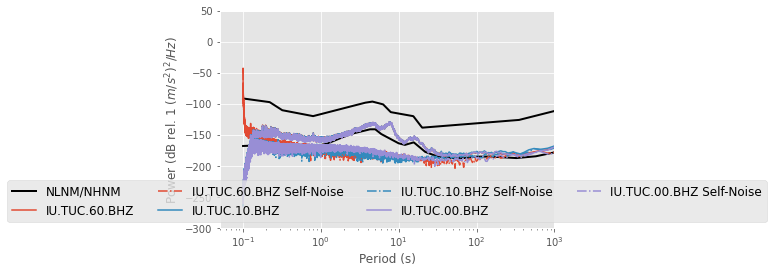

In [8]:
fig = plt.figure(1)

# We should add a reference model
per, nlnm = get_nlnm()
per, nhnm = get_nhnm()
plt.semilogx(per, nlnm, color='k', linewidth=2)
plt.semilogx(per, nhnm, color='k', linewidth=2, label='NLNM/NHNM')


for idx, tr in enumerate(st):
    resp, f = tr.stats.response.get_evalresp_response(tr.stats.delta, length,
                                                    output='ACC')
    f = f[1:]
    n[str(idx)] /= np.abs(resp[1:])**2
    p[str(idx)] /= np.abs(resp[1:])**2
    n[str(idx)] = 10.*np.log10(np.abs(n[str(idx)]))
    p[str(idx)] = 10.*np.log10(np.abs(p[str(idx)]))
    plt.semilogx(1./f,p[str(idx)], label=tr.id, color='C' + str(idx))
    plt.semilogx(1./f,n[str(idx)], label=tr.id + ' Self-Noise', color='C' + str(idx), linestyle='dashdot')
plt.legend(ncol=4, loc=8, fontsize=12)
plt.ylim((-300,50))
plt.xlim((1/20., (1000)))
plt.xlabel('Period (s)')
plt.ylabel('Power (dB rel. 1 $(m/s^2)^2/Hz$)')
plt.show()

Note in the above we have a density and we can not compare that to a signal directly. We can calculate again and integrate over a bandwidth. p*(2**(1/4) - 2**(-1/4))*f has units of m/s/s.

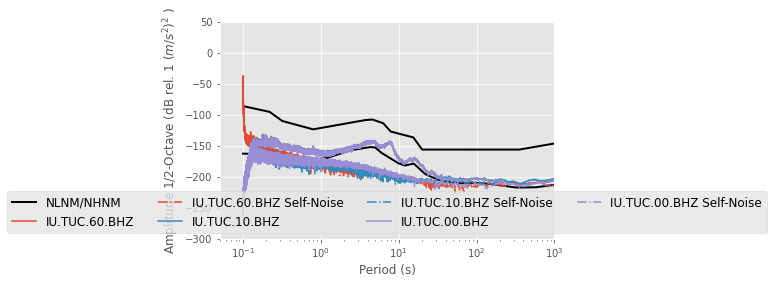

In [9]:
n, p, fre1 = selfnoise(st, length, overlap)

per, nlnm = get_nlnm()
per, nhnm = get_nhnm()
nlnm = np.sqrt(10**(nlnm/10.)*(2.**0.25 - 2.**(-0.25))/per)
nlnm = 20.*np.log10(nlnm)
nhnm = np.sqrt(10**(nhnm/10.)*(2.**0.25 - 2.**(-0.25))/per)
nhnm = 20.*np.log10(nhnm)
plt.semilogx(per, nlnm, color='k', linewidth=2)
plt.semilogx(per, nhnm, color='k', linewidth=2, label='NLNM/NHNM')

for idx, tr in enumerate(st):
    resp, f = tr.stats.response.get_evalresp_response(tr.stats.delta, length,
                                                    output='ACC')
    f = f[1:]
    n[str(idx)] /= np.abs(resp[1:])**2
    p[str(idx)] /= np.abs(resp[1:])**2
    # Now we integrate in 1/2-octave bands
    p[str(idx)] = p[str(idx)]*(2.**0.25 - 2.**(-0.25))*f
    n[str(idx)] = n[str(idx)]*(2.**0.25 - 2.**(-0.25))*f
    
    n[str(idx)] = 10.*np.log10(np.abs(n[str(idx)]))
    p[str(idx)] = 10.*np.log10(np.abs(p[str(idx)]))
    plt.semilogx(1./f,p[str(idx)], label=tr.id, color='C' + str(idx))
    plt.semilogx(1./f,n[str(idx)], label=tr.id + ' Self-Noise', color='C' + str(idx), linestyle='dashdot')
plt.legend(ncol=4, loc=8, fontsize=12)
plt.ylim((-300,50))
plt.xlim((1/20., (1000)))
plt.xlabel('Period (s)')
plt.ylabel('Amplitude 1/2-Octave (dB rel. 1 $(m/s^2)^2$ )')
plt.show()

We now have self-noise estimates that can be described in terms of a signal.  So we can now include a clip-level.

In [10]:
clip ={}
clip['0'], clip['1'], clip['2'] = 8*.707/1000., 13*.707/1000., 17*.707/1000.

These clip levels correspond to the rms of a sine wave 8 mm/s, 13 mm/s, and 17 mm/s for the STS-1, STS-2.5, and STS-6.

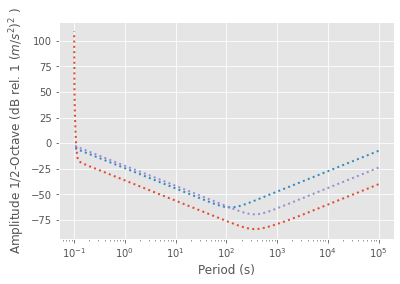

In [11]:
for idx, tr in enumerate(st):
    fnew = 1./per
    fnew = fnew[(fnew<=10.)]
    amp = tr.stats.response.get_evalresp_response_for_frequencies(fnew, output='Vel')
    amp = np.abs(amp/amp[-10])
    cliplev = 20*np.log10(clip[str(idx)]*(2.*np.pi)*fnew/amp)
    plt.semilogx(1./fnew, cliplev, label=tr.id + ' Clip Level', linewidth=2 , color='C' + str(idx) ,linestyle = ':')
    plt.xlabel('Period (s)')
    plt.ylabel('Amplitude 1/2-Octave (dB rel. 1 $(m/s^2)^2$ )')

There is probably a clever way to add the two figures, but since I don't know it we will just do it the long way.

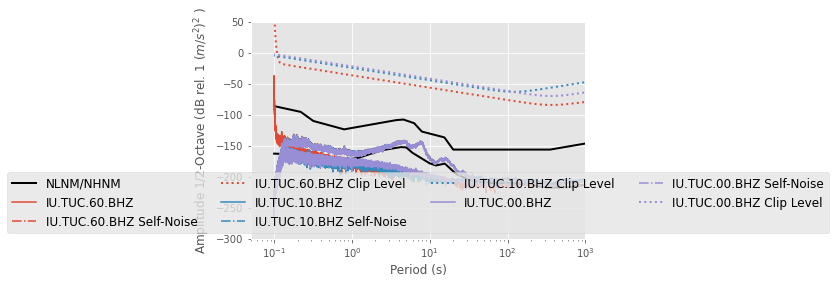

In [12]:
n, p, fre1 = selfnoise(st, length, overlap)

# Grabbing our noise models and plotting
per, nlnm = get_nlnm()
per, nhnm = get_nhnm()
nlnm = np.sqrt(10**(nlnm/10.)*(2.**0.25 - 2.**(-0.25))/per)
nlnm = 20.*np.log10(nlnm)
nhnm = np.sqrt(10**(nhnm/10.)*(2.**0.25 - 2.**(-0.25))/per)
nhnm = 20.*np.log10(nhnm)
plt.semilogx(per, nlnm, color='k', linewidth=2)
plt.semilogx(per, nhnm, color='k', linewidth=2, label='NLNM/NHNM')

for idx, tr in enumerate(st):
    resp, f = tr.stats.response.get_evalresp_response(tr.stats.delta, length,
                                                    output='ACC')
    # integrating our noise
    f = f[1:]
    n[str(idx)] /= np.abs(resp[1:])**2
    p[str(idx)] /= np.abs(resp[1:])**2
    # Now we integrate in 1/2-octave bands
    p[str(idx)] = p[str(idx)]*(2.**0.25 - 2.**(-0.25))*f
    n[str(idx)] = n[str(idx)]*(2.**0.25 - 2.**(-0.25))*f
    
    n[str(idx)] = 10.*np.log10(np.abs(n[str(idx)]))
    p[str(idx)] = 10.*np.log10(np.abs(p[str(idx)]))
    plt.semilogx(1./f,p[str(idx)], label=tr.id, color='C' + str(idx))
    plt.semilogx(1./f,n[str(idx)], label=tr.id + ' Self-Noise', color='C' + str(idx), linestyle='dashdot')
    # Grabbing our clip levels and plotting
    fnew = 1./per
    fnew = fnew[(fnew<=10.)]
    amp = tr.stats.response.get_evalresp_response_for_frequencies(fnew, output='Vel')
    amp = np.abs(amp/amp[-10])
    cliplev = 20*np.log10(clip[str(idx)]*(2.*np.pi)*fnew/amp)
    plt.semilogx(1./fnew, cliplev, label=tr.id + ' Clip Level', linewidth=2 , color='C' + str(idx) ,linestyle = ':')
    
    
plt.legend(ncol=4, loc=8, fontsize=12)
plt.ylim((-300,50))
plt.xlim((1/20., (1000)))
plt.xlabel('Period (s)')
plt.ylabel('Amplitude 1/2-Octave (dB rel. 1 $(m/s^2)^2$ )')
plt.show()

The ratio of the clip-level to the self-noise is the dynamic range of the instrument.  If we call it 140 dB that is the equivalent of a ruler across the US with markings every 0.2 m.